In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import time

In [22]:
df = pd.read_csv('diabetes.csv', encoding='utf-8')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

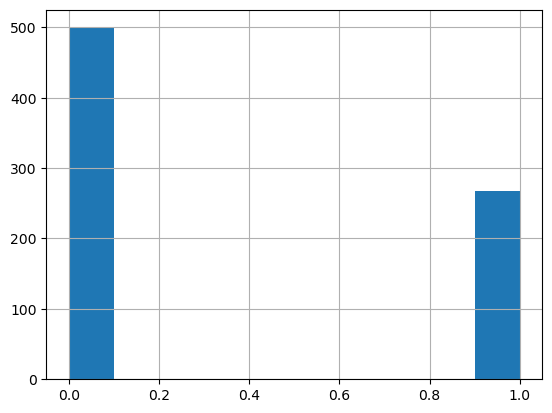

In [179]:
y = df['Outcome']
y.hist()

df.columns

In [61]:
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


minmaxScaler = MinMaxScaler()
minmaxScaler.fit(X_train)
minmaxScaler.transform(X_train)
minmaxScaler.fit(X_test)
minmaxScaler.transform(X_test)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)


# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.to_numpy())
y_train_tensor = torch.LongTensor(y_train.to_numpy())
X_test_tensor = torch.FloatTensor(X_test.to_numpy())
y_test_tensor = torch.LongTensor(y_test.to_numpy())

# Create a DataLoader for PyTorch
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [62]:
# Define a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=0.005)
dt_param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10],
                 'criterion': ['gini', 'entropy'], 'ccp_alpha': [0, 0.001, 0.005, 0.1, 0.5, 1]}

dt_classifier.fit(X_train_scaled, y_train)
y_pred = dt_classifier.predict(X_test)
print(dt_classifier.score(X_train_scaled, y_train))
print("f1 score dt_classifier:", f1_score(y_test, y_pred, average='weighted'))

dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=5)
dt_grid_search.fit(X_train_scaled, y_train)
dtgs = dt_grid_search.best_estimator_.fit(X_train, y_train)
dtgs.fit(X_train, y_train)
print(dtgs.score(X_train, y_train))
y_pred = dtgs.predict(X_test)
print("f1 score dt grid search:", f1_score(y_test, y_pred, average='weighted'))
dt_cross_val_scores = cross_val_score(dtgs, X=X_train, y=y_train, cv=5, scoring='f1_weighted')

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

# Print cross-validation scores
print(dt_cross_val_scores)  # Print accuracy for each fold
print(dt_cross_val_scores.mean())  # Print mean of accuracies for all folds
print(dt_cross_val_scores.std())  # Print SD for mean of all accuracies

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.8452768729641694
f1 score dt_classifier: 0.18796992481203006
0.8452768729641694
f1 score dt grid search: 0.7450410739330797
[[72 27]
 [13 42]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.78        99
           1       0.61      0.76      0.68        55

    accuracy                           0.74       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.74      0.75       154

[0.76606842 0.79494516 0.70879059 0.72932761 0.75409836]
0.750646025728495
0.02972720641469482


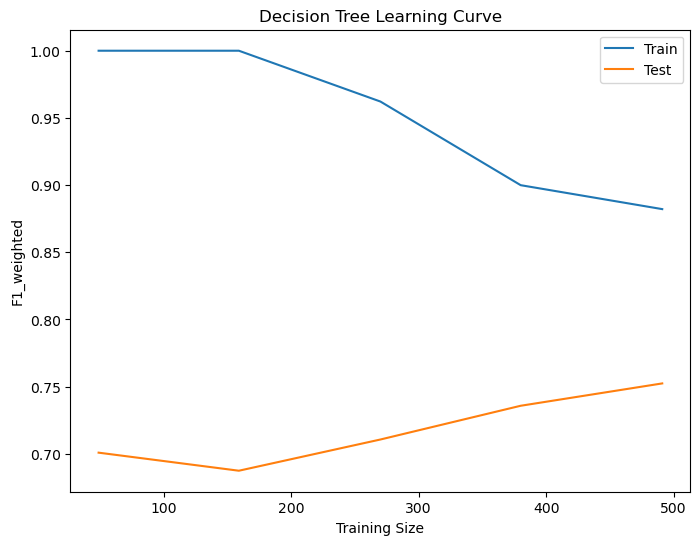

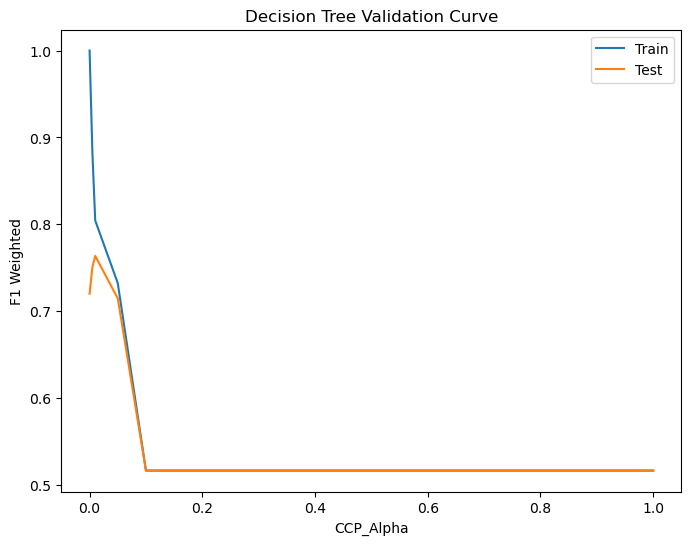

Accuracy: 0.7450410739330797
Training Time: 0.01003885269165039 seconds
Testing Time: 0.003 seconds


In [78]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    dt_classifier, X_train_scaled, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('F1_weighted')
plt.legend()
plt.title('Decision Tree Learning Curve')
plt.show()


# Validation Curve
param_range = [0, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1]  # Vary the max_depth parameter
train_scores, test_scores = validation_curve(
    dt_classifier, X_train, y_train, param_name="ccp_alpha", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('CCP_Alpha')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('Decision Tree Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
dt_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = dt_classifier.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time:.3f} seconds")

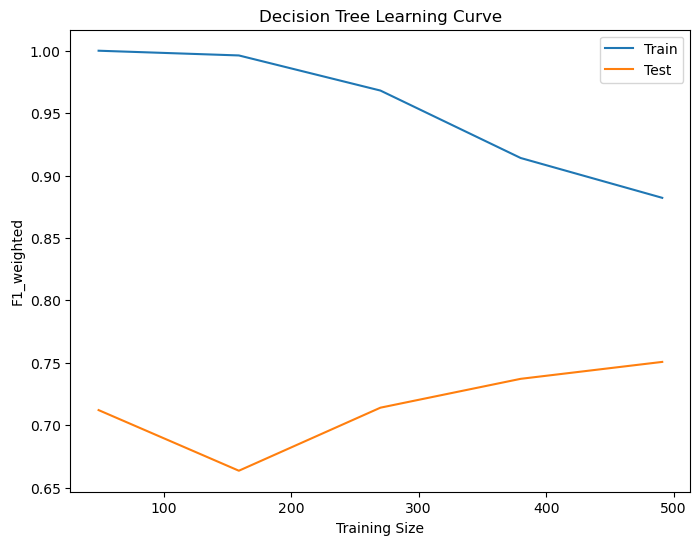

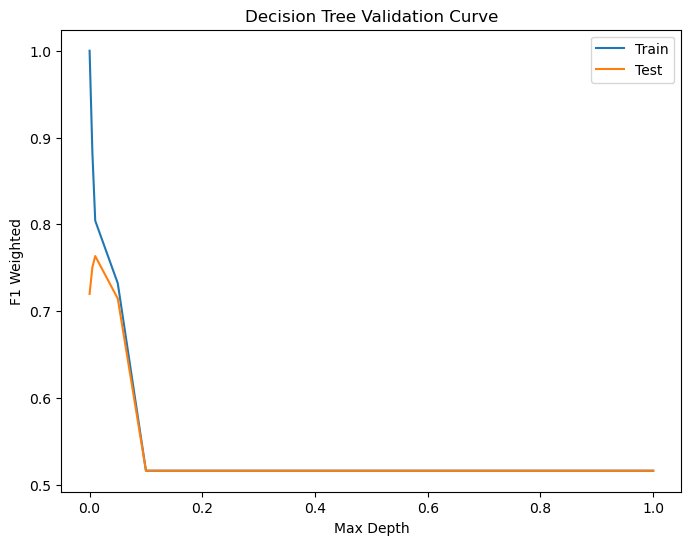

Accuracy: 0.7450410739330797
Training Time: 0.009320735931396484 seconds
Testing Time: 0.001 seconds


In [79]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    dtgs, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('F1_weighted')
plt.legend()
plt.title('Decision Tree Learning Curve')
plt.show()

# Validation Curve
param_range = [0, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1]  # Vary the max_depth parameter
train_scores, test_scores = validation_curve(
    dtgs, X_train, y_train, param_name="ccp_alpha", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Max Depth')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('Decision Tree Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
dtgs.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = dtgs.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time:.3f} seconds")

In [83]:
dt_grid_search.best_estimator_
dt_grid_search.best_params_

{'ccp_alpha': 0.005,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2}

In [178]:
# MLP Classifier (Neural Network)
mlp_classifier = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, validation_fraction=0.1, n_iter_no_change=10, random_state=42)
mlp_classifier.fit(X_train_tensor, y_train_tensor)
y_pred = mlp_classifier.predict(X_test)
print('f1 score initial', f1_score(y_test_tensor, y_pred, average='weighted'))

mlp_param_grid = {'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                  'alpha': [0.0001, 0.001, 0.01],
                 'activation': ['identity', 'logistic', 'tanh'],
                 'solver': ['sgd', 'adam'],
                 'learning_rate': ['constant', 'adaptive']}
mlp_grid_search = GridSearchCV(mlp_classifier, mlp_param_grid, cv=5, scoring='f1_weighted')
mlp_grid_search.fit(X_train_tensor, y_train_tensor)
mlpgs = mlp_grid_search.best_estimator_.fit(X_train_tensor, y_train_tensor)
mlp_cross_val_scores = cross_val_score(mlpgs, X=X_train, y=y_train, cv=5, scoring='f1_weighted')

print(mlp_cross_val_scores) # print accuracy for each fold
print(mlp_cross_val_scores.mean()) # print mean of accuracies for all folds
print(mlp_cross_val_scores.std()) # print SD for mean of all accuracies
print('\n')

y_pred = mlpgs.predict(X_test)
print('f1 score final', f1_score(y_test_tensor, y_pred, average='weighted')) 

print(classification_report(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


f1 score initial 0.5158002038735984


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neur

[0.68608642 0.68300551 0.61939112 0.58112217 0.73434626]
0.6607902954014628
0.05404589078940016


f1 score final 0.6516186516186516
              precision    recall  f1-score   support

           0       0.70      0.95      0.80        99
           1       0.74      0.25      0.38        55

    accuracy                           0.70       154
   macro avg       0.72      0.60      0.59       154
weighted avg       0.71      0.70      0.65       154



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


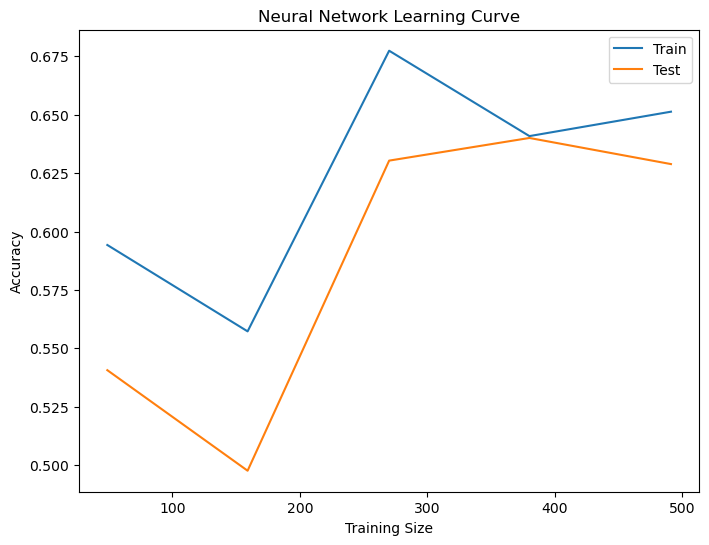

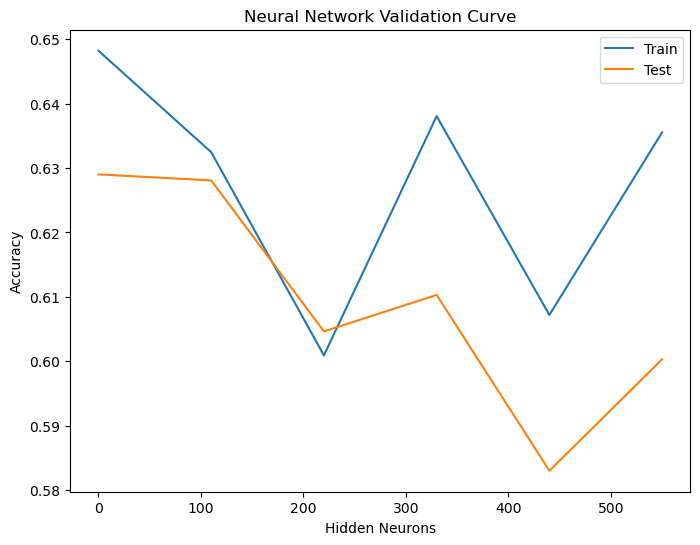

Accuracy: 0.5158002038735984
Training Time: 0.06406497955322266 seconds
Testing Time: 0.001 seconds


In [87]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlp_classifier, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlp_classifier, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=5, scoring='f1_weighted')

param_range = np.linspace(0, 550, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
mlp_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = mlp_classifier.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time:.3f} seconds")

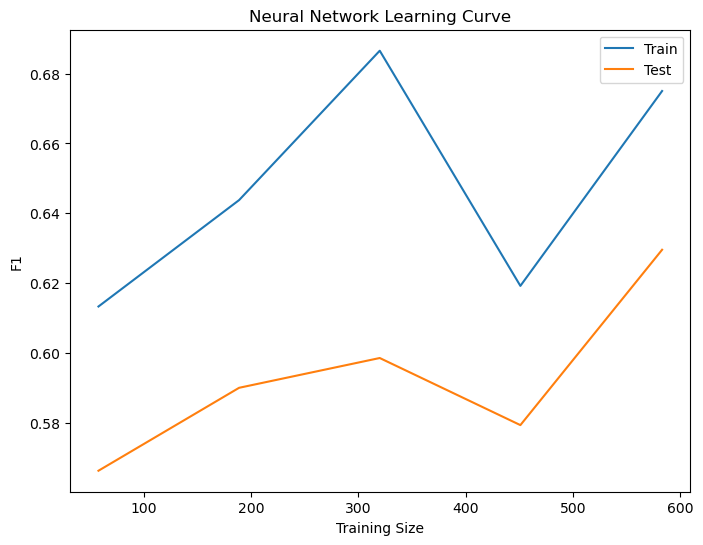

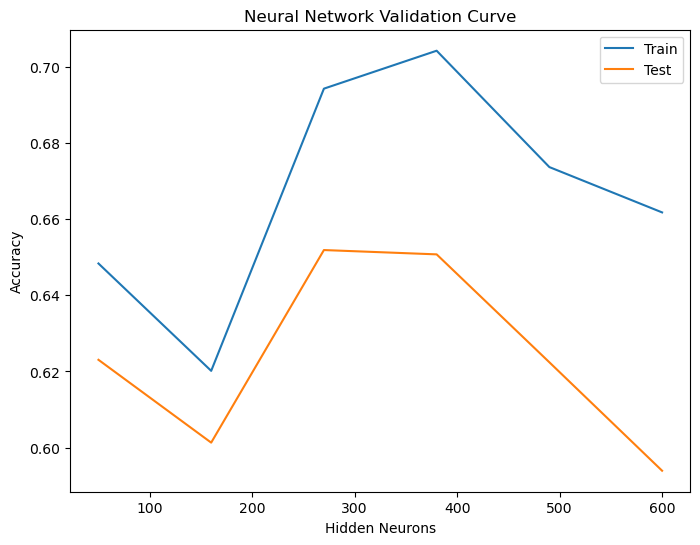

F1: 0.6516186516186516
Training Time: 0.09782600402832031 seconds
Testing Time: 0.002 seconds


In [93]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    mlpgs, X_train, y_train, cv=20, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('F1')
plt.legend()
plt.title('Neural Network Learning Curve')
plt.show()

# Validation Curve
param_range = [(50,), (100,), (50, 100), (100,100), (150), (200)]  # Vary the number of hidden neurons
train_scores, test_scores = validation_curve(
    mlpgs, X_train, y_train, param_name="hidden_layer_sizes", param_range=param_range,
    cv=10, scoring='f1_weighted')

param_range = np.linspace(50, 600, 6)
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Hidden Neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
mlpgs.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = mlpgs.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time:.3f} seconds")

In [85]:
mlp_grid_search.best_estimator_

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)

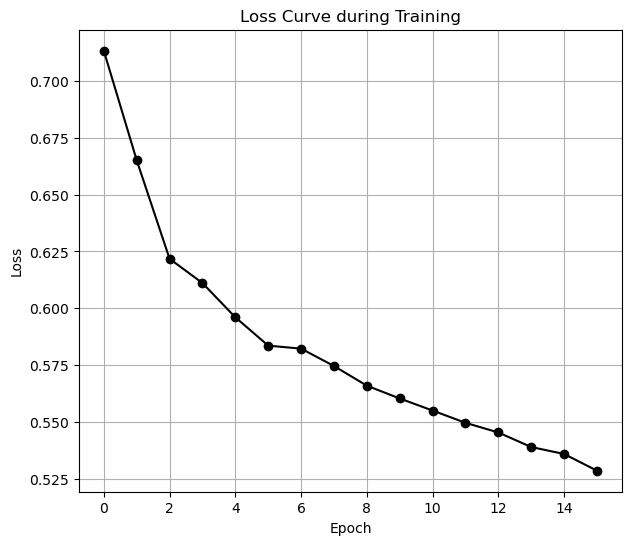

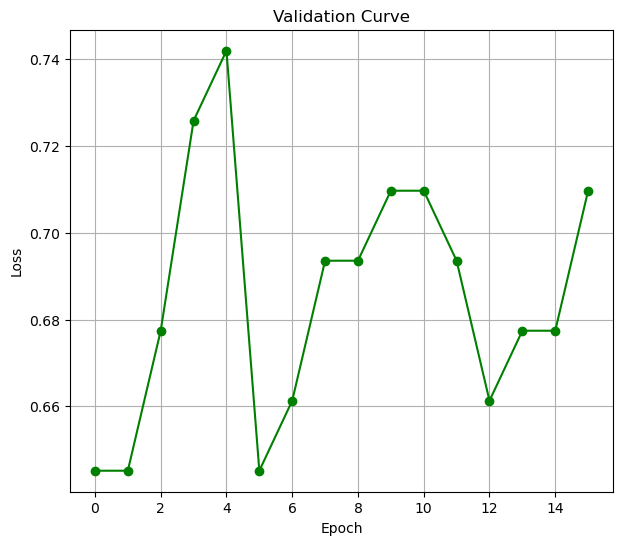

In [162]:
loss_curve = mlp_grid_search.best_estimator_.loss_curve_

# Plot the loss curve
plt.figure(figsize=(7, 6))
plt.plot(loss_curve, marker='o', color='black')
plt.title('Loss Curve during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

val_curve = mlp_grid_search.best_estimator_.validation_scores_
plt.figure(figsize=(7, 6))
plt.plot(val_curve, marker='o', color='green')
plt.title('Validation Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

In [100]:
# Define a Decision Tree classifier (base learner)
base_classifier = DecisionTreeClassifier(max_depth=1, ccp_alpha=0.005)

# Define an AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

adaboost_classifier.fit(X_train, y_train)
y_pred = adaboost_classifier.predict(X_test)
print('f1 score initial', f1_score(y_test, y_pred)) 
adaboost_param_grid = {'n_estimators': [50, 100, 200],
                 'learning_rate': [0.5, 1.5, 2],
                 'algorithm': ['SAMME','SAMME.R']}
adaboost_grid_search = GridSearchCV(adaboost_classifier, adaboost_param_grid, cv=5, scoring='f1_weighted')
adaboost_grid_search.fit(X_train, y_train)
adabgs = adaboost_grid_search.best_estimator_.fit(X_train, y_train)
      
adaboost_cross_val_scores = cross_val_score(adabgs, X=X_train, y=y_train, cv=5, scoring='f1_weighted')
print(adaboost_cross_val_scores) # print accuracy for each fold
print(adaboost_cross_val_scores.mean()) # print mean of accuracies for all folds
print(adaboost_cross_val_scores.std()) # print SD for mean of all accuracies

y_pred = adabgs.predict(X_test)
print('f1 score final', f1_score(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

f1 score initial 0.6551724137931035
[0.77096966 0.82011299 0.72317176 0.7375914  0.78824328]
0.7680178199060073
0.0348385563521911
f1 score final 0.6727272727272727
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        99
           1       0.67      0.67      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



In [99]:
adaboost_grid_search.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 50}

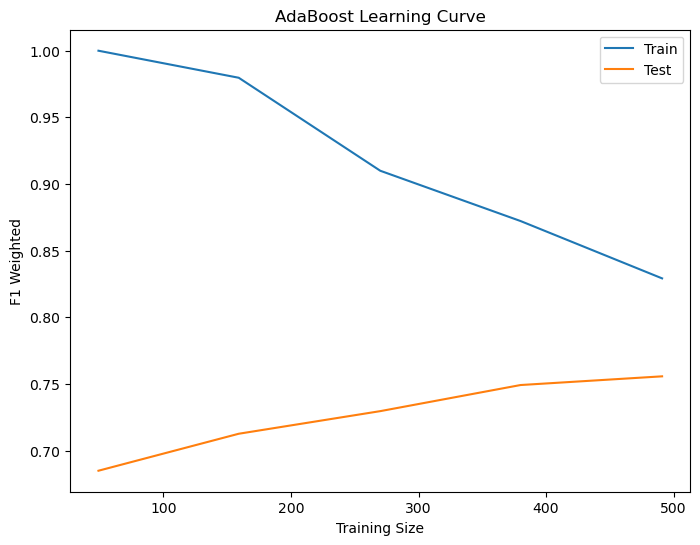

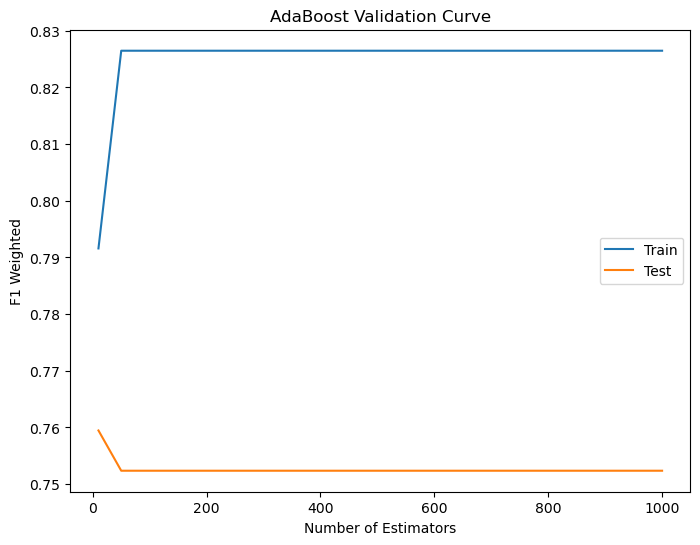

F1 Score: 0.7429187192118227
Training Time: 0.12781500816345215 seconds
Testing Time: 0.011333227157592773 seconds


In [98]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    adaboost_classifier, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('AdaBoost Learning Curve')
plt.show()

# Validation Curve
param_range = [10, 50, 100, 250, 500, 1000]  # Vary the number of estimators
train_scores, test_scores = validation_curve(
    adaboost_classifier, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('AdaBoost Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
adaboost_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = adaboost_classifier.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

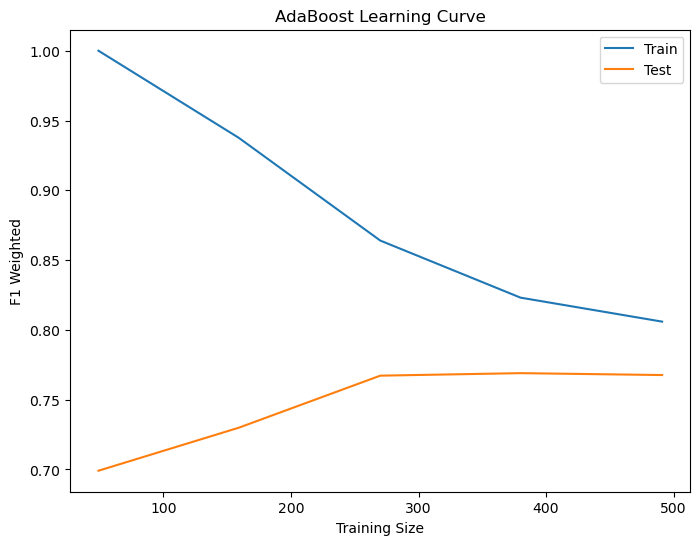

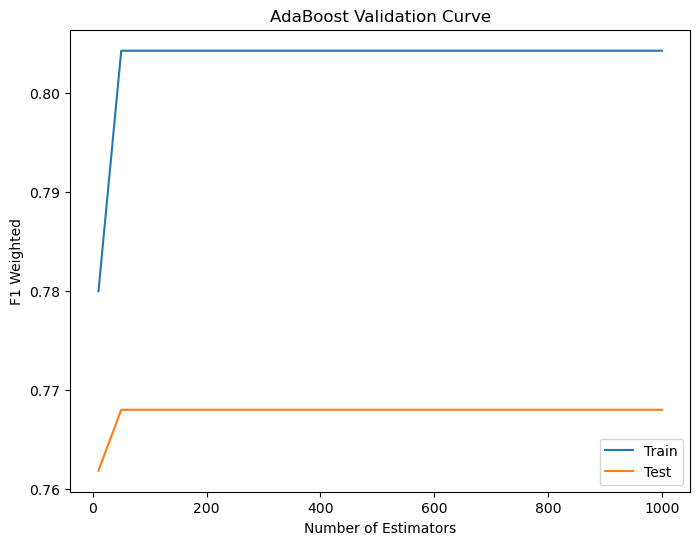

F1 Score: 0.7662337662337663
Training Time: 0.14397001266479492 seconds
Testing Time: 0.010196685791015625 seconds


In [89]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    adabgs, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('AdaBoost Learning Curve')
plt.show()

# Validation Curve
param_range = [10, 50, 100, 250, 500, 1000]  # Vary the number of estimators
train_scores, test_scores = validation_curve(
    adabgs, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Weighted')
plt.legend()
plt.title('AdaBoost Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
adabgs.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = adabgs.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

In [101]:
# Define an SVM classifier
svc_classifier = SVC(kernel='linear', C=1, random_state=42, probability=True)

svc_param_grid = {'C': [0.1, 1, 2, 4, 6],
                  'kernel': ['linear', 'rbf', 'sigmoid']
                 }

svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)
print('f1 score initial', f1_score(y_test_tensor, y_pred, average='weighted')) 
svc_grid_search = GridSearchCV(svc_classifier, svc_param_grid, cv=5, scoring='f1_weighted')
svc_grid_search.fit(X_train, y_train)
svcgs = svc_grid_search.best_estimator_.fit(X_train, y_train)

svc_cross_val_scores = cross_val_score(svcgs, X=X_train, y=y_train, cv=5, scoring='f1_weighted')
print(svc_cross_val_scores) # print accuracy for each fold
print(svc_cross_val_scores.mean()) # print mean of accuracies for all folds
print(svc_cross_val_scores.std()) # print SD for mean of all accuracies

y_pred = svcgs.predict(X_test)
print('f1 score final', f1_score(y_test, y_pred, average='weighted')) 

print(classification_report(y_test, y_pred))  

f1 score initial 0.7532467532467533
[0.75461035 0.80530975 0.7375914  0.72501012 0.77326718]
0.7591577612999177
0.028216766815253723
f1 score final 0.7532467532467533
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



In [174]:
svc_grid_search.best_estimator_

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [172]:
svc_poly = SVC(kernel='rbf', C=1, random_state=42, probability=True)
svc_poly.fit(X_train, y_train)
y_pred = svc_poly.predict(X_test)
print('f1 score poly', f1_score(y_test, y_pred, average='weighted')) 

f1 score poly 0.758600583090379


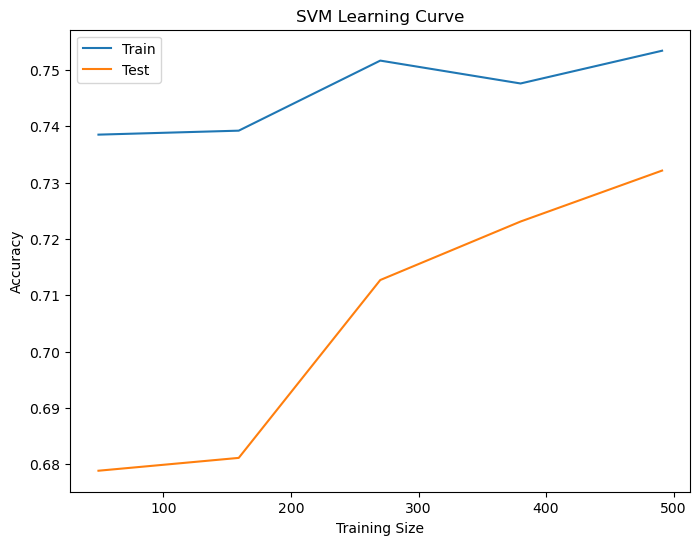

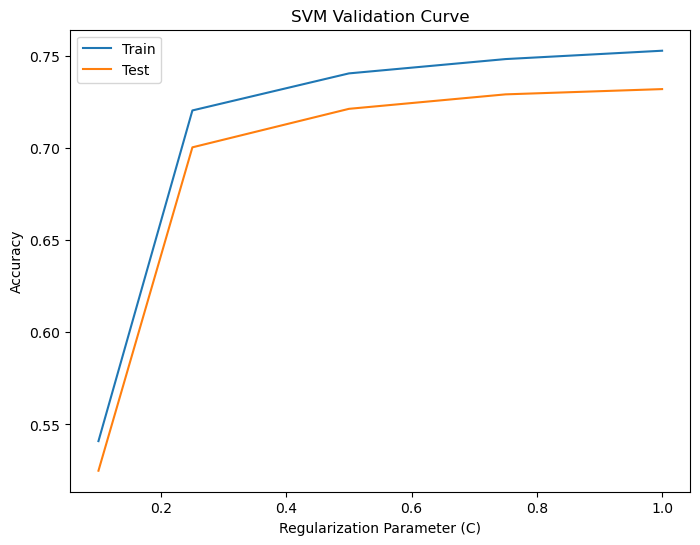

F1 Score: 0.758600583090379
Training Time: 17.83055591583252 seconds
Testing Time: 0.007999181747436523 seconds


In [173]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    svc_poly, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Learning Curve')
plt.show()

# Validation Curve
param_range = [0.1, 0.25, 0.5, 0.75, 1]  # Vary the regularization parameter C
train_scores, test_scores = validation_curve(
    svc_poly, X_train, y_train, param_name="C", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
svm_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = svc_poly.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

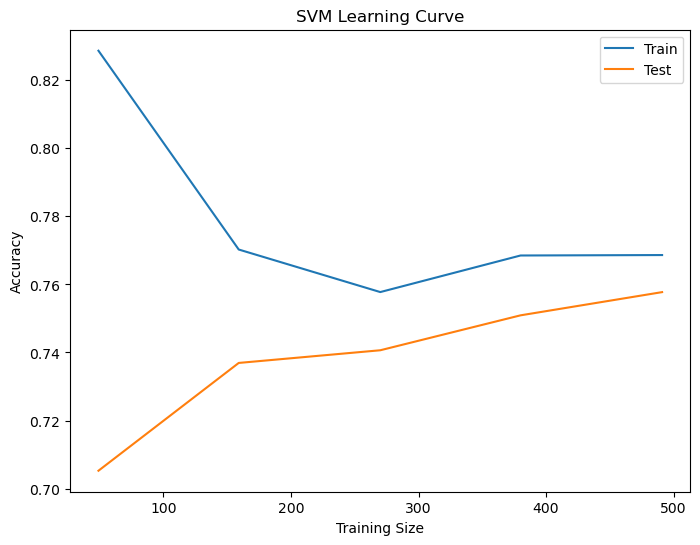

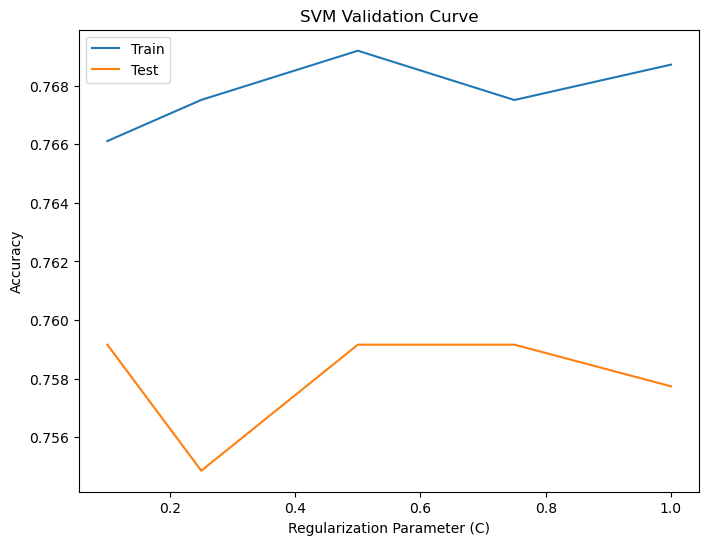

F1 Score: 0.7532467532467533
Training Time: 14.987266302108765 seconds
Testing Time: 0.0032711029052734375 seconds


In [102]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    svm_classifier, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Learning Curve')
plt.show()

# Validation Curve
param_range = [0.1, 0.25, 0.5, 0.75, 1]  # Vary the regularization parameter C
train_scores, test_scores = validation_curve(
    svm_classifier, X_train, y_train, param_name="C", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
svm_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = svm_classifier.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

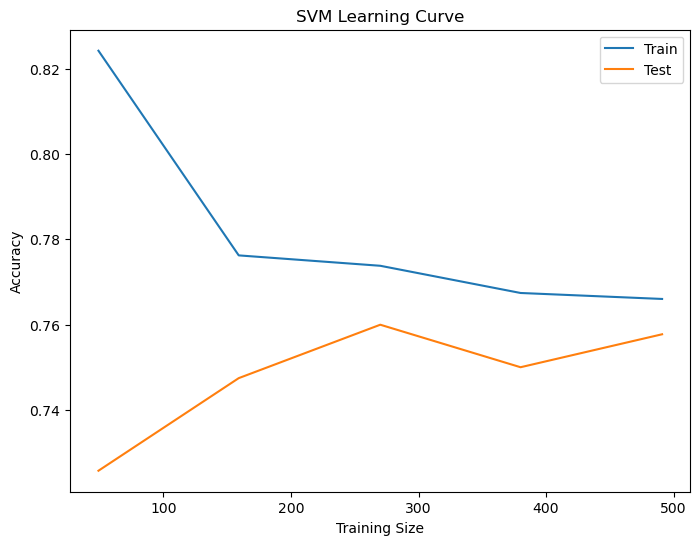

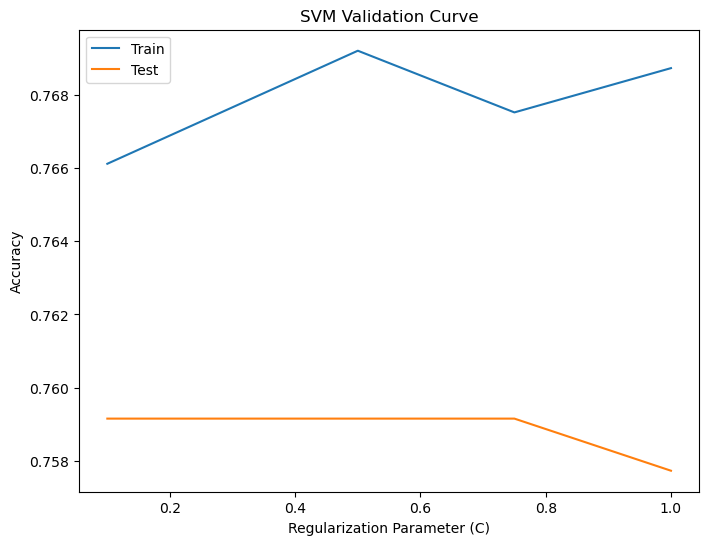

F1 Score: 0.7532467532467533
Training Time: 1.2368295192718506 seconds
Testing Time: 0.0022161006927490234 seconds


In [113]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    svcgs, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Learning Curve')
plt.show()

# Validation Curve
param_range = [0.1, 0.5, 0.75, 1]  # Vary the regularization parameter C
train_scores, test_scores = validation_curve(
    svcgs, X_train, y_train, param_name="C", param_range=param_range,
    cv=5, scoring='f1_weighted')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
svcgs.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = svcgs.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

In [176]:
# k-Nearest Neighbors Classifier (KNN)
knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 10, 12, 16, 25],
                  'weights': ['uniform', 'distance'],
                 'algorithm': ['ball_tree', 'kd_tree'],
                 'metric': ['minkowski', 'l2', 'euclidean']}

knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
print('f1 score initial', f1_score(y_test, y_pred, average='weighted')) 
      
knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=5, scoring='f1_weighted', return_train_score=True)
knn_grid_search.fit(X_train, y_train)
knngs = knn_grid_search.best_estimator_.fit(X_train, y_train)
y_pred = knngs.predict(X_test)
print('f1 score final', f1_score(y_test, y_pred, average='weighted')) 

knnc_cross_val_scores = cross_val_score(knngs, X=X_train, y=y_train, cv=10, scoring='f1_weighted')
print(knnc_cross_val_scores) # print accuracy for each fold
print(knnc_cross_val_scores.mean()) # print mean of accuracies for all folds
print(knnc_cross_val_scores.std()) # print SD for mean of all accuracies

 
print(classification_report(y_test, y_pred))

f1 score initial 0.7601648351648352
f1 score final 0.7153790087463556
[0.68716976 0.71629446 0.79792317 0.70967742 0.67664    0.78560181
 0.71876918 0.74908461 0.76387691 0.78254   ]
0.7387577292391626
0.04076660140755519
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        99
           1       0.60      0.62      0.61        55

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.71      0.72       154



In [177]:
knn_grid_search.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10, weights='distance')

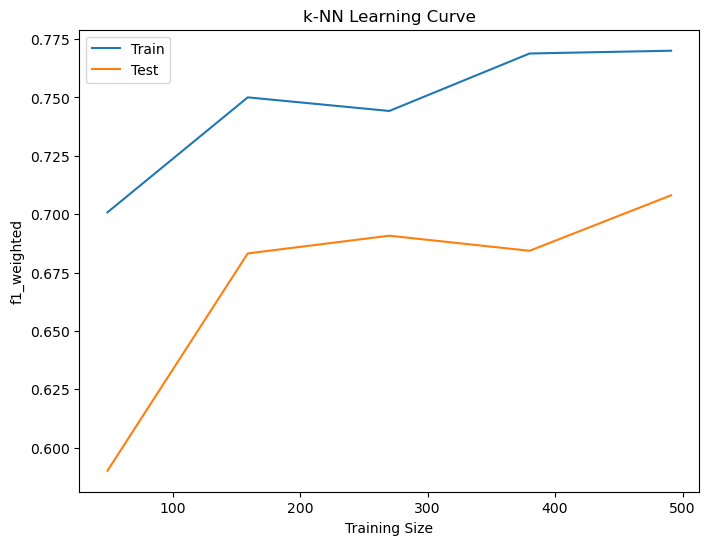

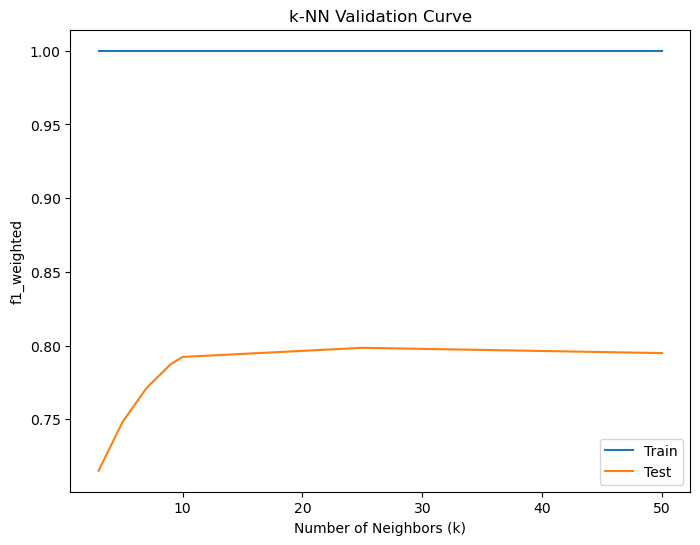

F1 Score: 0.7601648351648352
Training Time: 0.003995656967163086 seconds
Testing Time: 0.013360023498535156 seconds


In [181]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_classifier, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('f1_weighted')
plt.legend()
plt.title('k-NN Learning Curve')
plt.show()

# Validation Curve
param_range = [3, 5, 7, 9, 10, 25, 50]  # Vary the number of neighbors (k)
train_scores, test_scores = validation_curve(
    knngs, X_train, y_train, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring='roc_auc')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('f1_weighted')
plt.legend()
plt.title('k-NN Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
knn_classifier.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = knn_classifier.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")

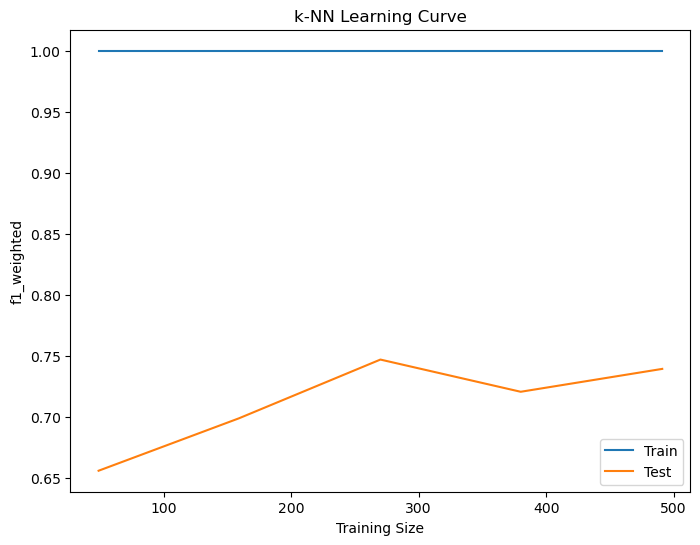

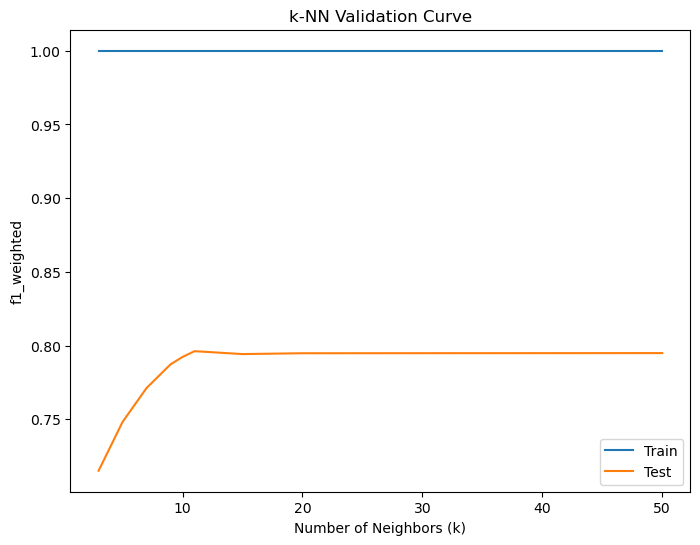

F1 Score: 0.7153790087463556
Training Time: 0.002290487289428711 seconds
Testing Time: 0.004001140594482422 seconds


In [156]:
train_sizes, train_scores, test_scores = learning_curve(
    knn_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_weighted', shuffle=True)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('f1_weighted')
plt.legend()
plt.title('k-NN Learning Curve')
plt.show()

# Validation Curve
param_range = [3, 5, 7, 9, 10, 11, 15, 20, 50]  # Vary the number of neighbors (k)
train_scores, test_scores = validation_curve(
    knngs, X_train, y_train, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring='roc_auc')

plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Test')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('f1_weighted')
plt.legend()
plt.title('k-NN Validation Curve')
plt.show()

# Measure Wall Clock Time
start_time = time.time()
knngs.fit(X_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = knngs.predict(X_test)
testing_time = time.time() - start_time

accuracy = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Score: {accuracy}")
print(f"Training Time: {training_time} seconds")
print(f"Testing Time: {testing_time} seconds")